# Housing Price Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
prices = pd.read_csv('../data/Ames_Housing_Price_Data.csv',index_col = 0)
latlon = pd.read_csv('../data/full_latlon.csv')

In [2]:
prices.reset_index(drop = True, inplace = True)
nulls = prices.isnull().sum(axis = 0)
nulls[nulls>1]

LotFrontage      462
Alley           2412
MasVnrType        14
MasVnrArea        14
BsmtQual          69
BsmtCond          69
BsmtExposure      71
BsmtFinType1      69
BsmtFinType2      70
BsmtFullBath       2
BsmtHalfBath       2
FireplaceQu     1241
GarageType       127
GarageYrBlt      129
GarageFinish     129
GarageQual       129
GarageCond       129
PoolQC          2571
Fence           2055
MiscFeature     2483
dtype: int64

In [3]:
#Merge housing data with coordinate data
prices = pd.merge(prices, latlon, how='left', left_on = 'PID', right_on = 'PID' )
prices.drop('coord',axis = 1,inplace = True)

In [4]:
#Exclude neighborhoods outside the Ames, IA city limits
prices = prices.drop_duplicates()
prices = prices.loc[~prices['Neighborhood'].isin(['Landmrk','Greens','GrnHill'])]

### Convert distances from km to miles

In [5]:
prices[['dist_airport','dist_downtown','dist_stadium']] = prices[['dist_airport','dist_downtown',
                                                                 'dist_stadium']].apply(lambda D: D*0.621371)

In [6]:
#Impute the following missing values with the mode
prices['MasVnrType'].fillna(prices['MasVnrType'].mode()[0],inplace = True)
prices['MasVnrArea'].fillna(prices['MasVnrArea'].mode()[0],inplace = True)
prices['Electrical'].fillna(prices['Electrical'].mode()[0],inplace = True)

In [7]:
#Creating a price per square foot column to help with feature engineering
prices['Price_sqft'] = prices['SalePrice']/prices['GrLivArea']

#Create copy for tree-based models
tree_prices = prices.copy()

# Converting quality/condition categoricals to numerical

In [8]:
def ordinal_scale(Series):
    '''Returns a pandas Series where quality scores are converted to integers
    
    Args:
    
    Series: a pandas Series of categorical quality scores'''
    return Series.replace({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

In [9]:
prices['KitchenQual'] = ordinal_scale(prices['KitchenQual'])
prices['ExterQual'] = ordinal_scale(prices['ExterQual'])
prices['ExterCond'] = ordinal_scale(prices['ExterCond'])
prices['HeatingQC'] = ordinal_scale(prices['HeatingQC'])

In [10]:
def fillna_cats(Series):
    '''
    Returns a categorical pandas series replacing null values with DNE (Does Not Exist).
    
    Args:
    

    Series: str, column name in the pandas dataframe.
    '''
    Series.fillna('DNE',inplace = True)
    return Series

In [11]:
impute_cols = ['Alley','BsmtExposure','BsmtFinType1',
               'BsmtFinType2','Fence','GarageType']
ordinal_cols = ['BsmtQual','BsmtCond','FireplaceQu','GarageQual',
                'GarageCond','PoolQC','GarageFinish']

for i in impute_cols:
    prices[i] = fillna_cats(prices[i])
    tree_prices[i] =  fillna_cats(tree_prices[i])

for j in ordinal_cols:
    prices[j] = fillna_cats(prices[j])
    tree_prices[j] = fillna_cats(tree_prices[j])

In [12]:
def impute_by_neighborhood(df,Series,method):
    '''Returns series with missing values imputed by specifed method.
    
    Args:
    
    df: pd.Dataframe, Dataframe to pass in
    Series: str, column name in df
    method: str, Central tendency method by which to impute (examples: "mean","median")
    '''
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError('df argument must be of type pd.DataFrame')
        
    if not isinstance(Series, str):
        raise TypeError('Series but be the column name as a string')
    return df[Series].fillna(df.groupby('Neighborhood')[Series].transform(method))

In [13]:
tree_prices['MiscFeature'] = fillna_cats(tree_prices['MiscFeature'])
tree_prices['LotFrontage'] = impute_by_neighborhood(tree_prices,'LotFrontage','mean')
tree_prices['GarageYrBlt'] = impute_by_neighborhood(tree_prices,'GarageYrBlt','median')


prices['LotFrontage'] = impute_by_neighborhood(prices,'LotFrontage','mean')
prices['GarageYrBlt'] = impute_by_neighborhood(prices,'GarageYrBlt','median')


#fill remaining missing columns with the column mean
tree_prices = tree_prices.fillna(tree_prices.mean())

tree_nulls = tree_prices.isnull().sum()
tree_nulls[tree_nulls>1]

Series([], dtype: int64)

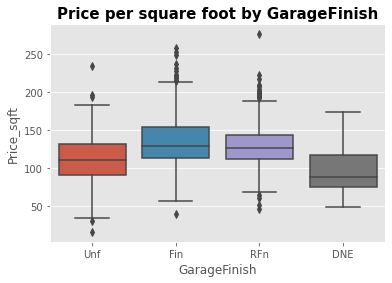

In [14]:
def cat_boxplots(Series):
    import seaborn as sns
    import matplotlib.pyplot as plt
    #bars = prices.groupby(Series)['SalePrice'].median().reset_index().sort_values(by = 'SalePrice')
    plt.title(f'Price per square foot by {Series}',fontsize = 15, fontweight = 'bold')
    plt.xlabel(Series)
    plt.ylabel('Price per sqft (USD)')
    sns.boxplot(data = prices, x = Series,y = 'Price_sqft')
    plt.show()

cat_boxplots('GarageFinish')

## Convert columns to numerical for linear regression

In [15]:
for i in ordinal_cols:
    prices[i].replace({'Po':0,'DNE':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace = True)
    
prices['MiscFeature'].fillna(0,inplace = True)
prices['GarageFinish'] = prices['GarageFinish'].replace({'DNE':1, 'Unf':2, 'RFn':3, 'Fin':4})
prices['MiscFeature'] = prices['MiscFeature'].apply(lambda M: 1 if M !=0 else M)
prices['CentralAir'].replace({'N':0,'Y':1},inplace = True)
prices['Street'].replace({'Grvl':0,'Pave':1},inplace = True)
prices['PavedDrive'].replace({'Y':1,'P':0.5,'N':0},inplace = True)
prices['Utilities'].replace({'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1},inplace = True)    

In [16]:
prices = prices.fillna(prices.mean())
nulls = prices.isnull().sum(axis = 0)
nulls[nulls>1]

Series([], dtype: int64)

### Differences in neighborhood development

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'SWISU'),
  Text(1, 0, 'Edwards'),
  Text(2, 0, 'IDOTRR'),
  Text(3, 0, 'OldTown'),
  Text(4, 0, 'NWAmes'),
  Text(5, 0, 'Blmngtn'),
  Text(6, 0, 'Mitchel'),
  Text(7, 0, 'NridgHt'),
  Text(8, 0, 'NAmes'),
  Text(9, 0, 'CollgCr'),
  Text(10, 0, 'SawyerW'),
  Text(11, 0, 'MeadowV'),
  Text(12, 0, 'BrDale'),
  Text(13, 0, 'Gilbert'),
  Text(14, 0, 'Timber'),
  Text(15, 0, 'Somerst'),
  Text(16, 0, 'BrkSide'),
  Text(17, 0, 'NoRidge'),
  Text(18, 0, 'Sawyer'),
  Text(19, 0, 'Crawfor'),
  Text(20, 0, 'ClearCr'),
  Text(21, 0, 'StoneBr'),
  Text(22, 0, 'Veenker'),
  Text(23, 0, 'NPkVill'),
  Text(24, 0, 'Blueste')])

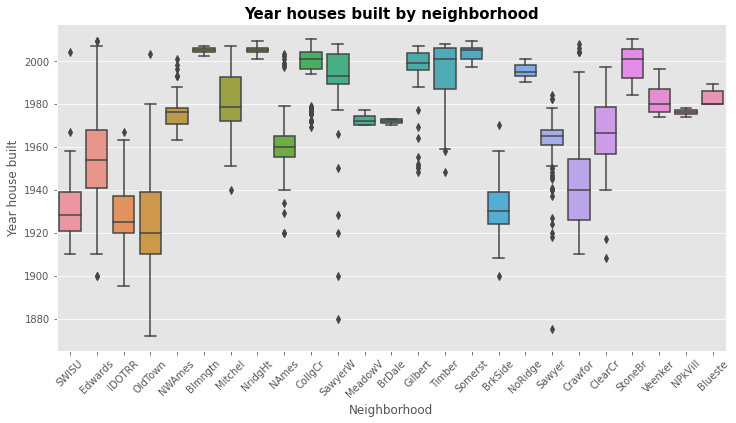

In [17]:
plt.figure(figsize = (12,6))
plt.title('Year houses built by neighborhood', fontsize = 15, fontweight = 'bold')
sns.boxplot(data = prices, x = 'Neighborhood', y = 'YearBuilt')
plt.ylabel('Year house built')
plt.xticks(rotation = 45,labels=None)

<p>Imputing certain columns by neighborhood works better for time series data than simply using a measure from the entire dataset.</p>

# Selecting numerical variables for multiple linear regression

In [18]:
numeric_features = prices.select_dtypes(include = np.number).copy()


y_Logprice = np.log(numeric_features['SalePrice'])
numeric_features.drop(['PID','SalePrice','Price_sqft','MSSubClass'], axis = 1, inplace = True)

# Correlations of numerical features

Text(0.5, 1.0, 'Evaluating multicollinearity of predictors')

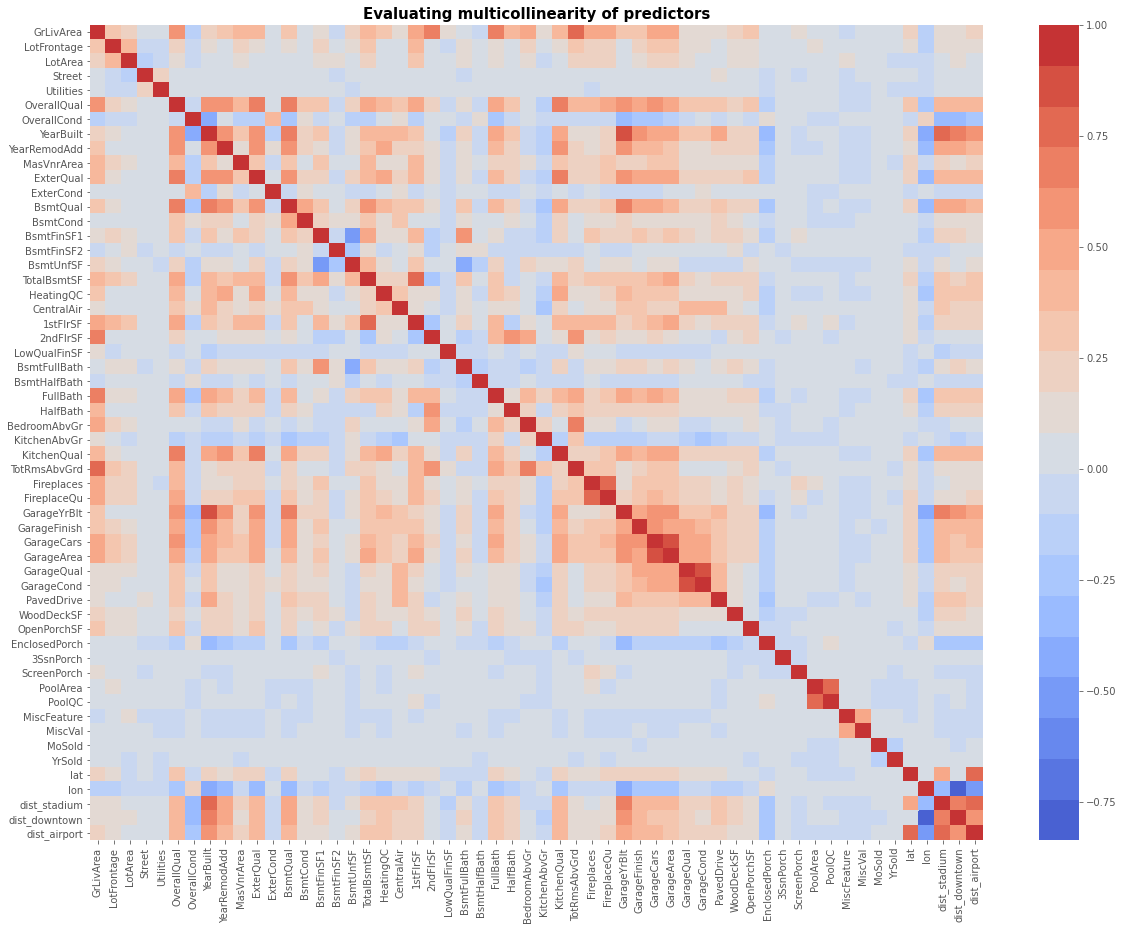

In [19]:
plt.figure(figsize = (20,15))
colormap = sns.color_palette('coolwarm',20)
sns.heatmap(numeric_features.corr(),cmap = colormap)
plt.title('Evaluating multicollinearity of predictors', fontsize= 15, fontweight = 'bold')

In [20]:
#Using original dataset to show correlations between price and each feature
r_prices = prices.corr()
r_prices = r_prices[['SalePrice']][1:]

Text(0.5, 1.0, 'Correlation between each feature and house price')

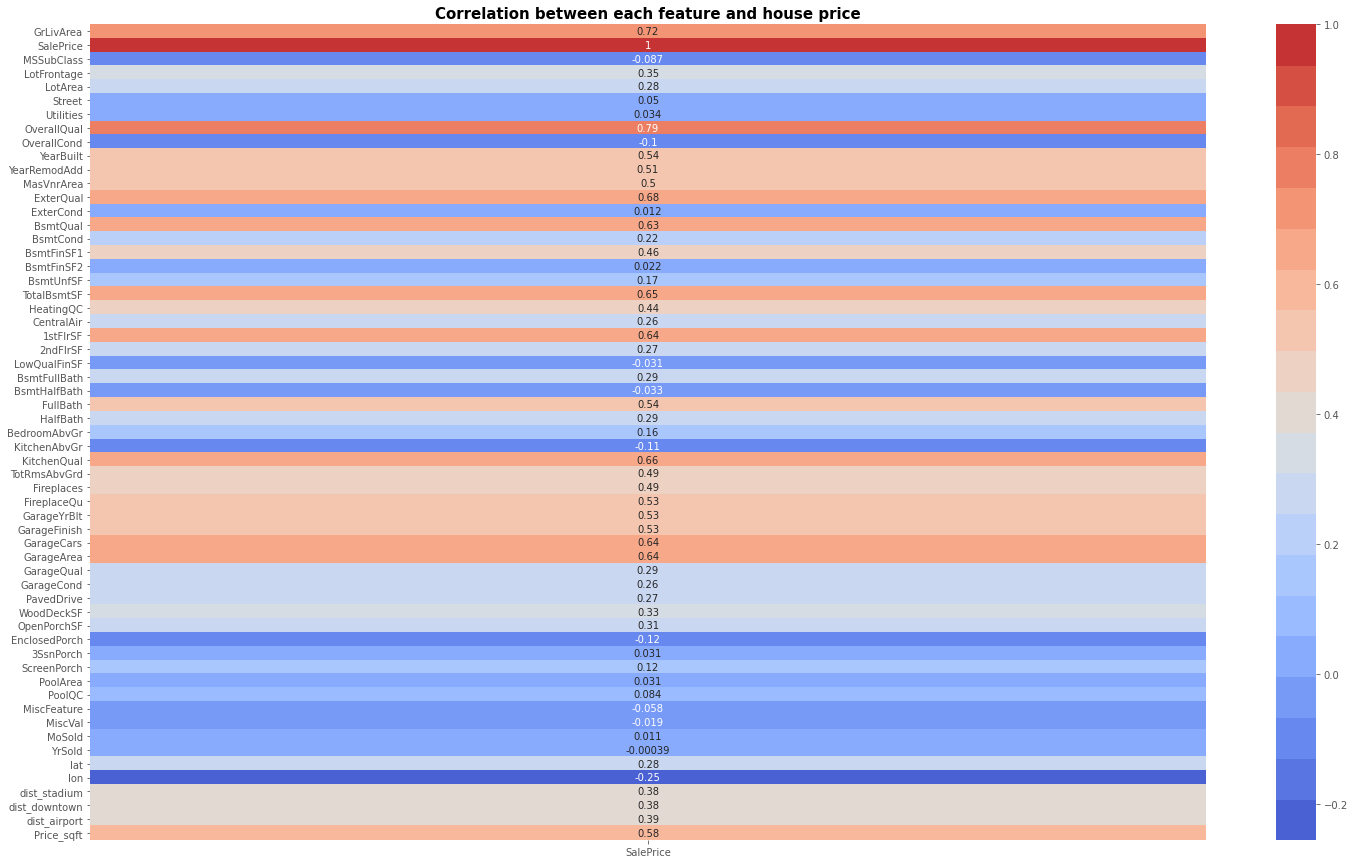

In [21]:
plt.figure(figsize = (25,15))
sns.heatmap(r_prices,annot = True,cmap = colormap)
plt.title('Correlation between each feature and house price', fontsize = 15, fontweight = 'bold')

In [22]:
numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2568 entries, 0 to 2629
Data columns (total 56 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2568 non-null   int64  
 1   LotFrontage    2568 non-null   float64
 2   LotArea        2568 non-null   int64  
 3   Street         2568 non-null   int64  
 4   Utilities      2568 non-null   int64  
 5   OverallQual    2568 non-null   int64  
 6   OverallCond    2568 non-null   int64  
 7   YearBuilt      2568 non-null   int64  
 8   YearRemodAdd   2568 non-null   int64  
 9   MasVnrArea     2568 non-null   float64
 10  ExterQual      2568 non-null   int64  
 11  ExterCond      2568 non-null   int64  
 12  BsmtQual       2568 non-null   int64  
 13  BsmtCond       2568 non-null   int64  
 14  BsmtFinSF1     2568 non-null   float64
 15  BsmtFinSF2     2568 non-null   float64
 16  BsmtUnfSF      2568 non-null   float64
 17  TotalBsmtSF    2568 non-null   float64
 18  HeatingQ

# Distribution of numerical variables

Median is $159,500.00
Mean is $177,941.81


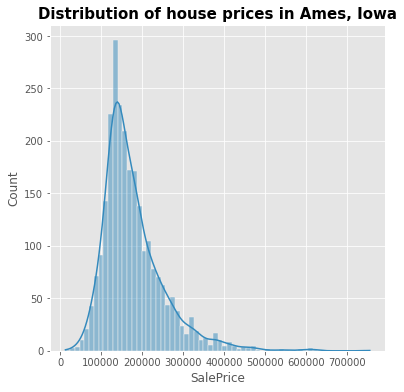

In [23]:
plt.figure(figsize = (6,6))
sns.histplot(prices.SalePrice,kde = True)
plt.title('Distribution of house prices in Ames, Iowa', fontsize = 15, fontweight = 'bold')
print('Median is ${:,.2f}'.format(np.median(prices.SalePrice)))
print('Mean is ${:,.2f}'.format(round(np.mean(prices.SalePrice),2)))

<Figure size 720x720 with 0 Axes>

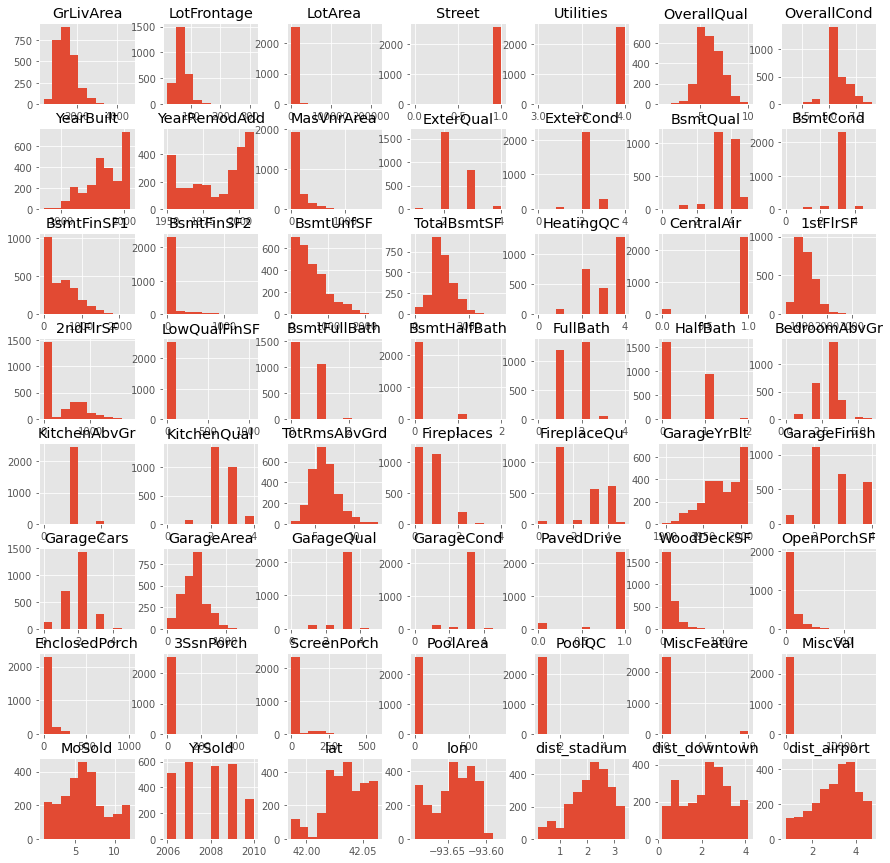

In [24]:
plt.figure(figsize = (10,10))
numeric_features.hist(figsize = (15,15))
plt.show()

# Feature Selection

#### Using five-fold CV to determine best hyperparameters for Lasso regression

In [25]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score



Xtrain,Xtest,ytrain,ytest = train_test_split(numeric_features,y_Logprice)

sc = StandardScaler()
cv = KFold(n_splits = 5, shuffle = True)


lasso = Lasso(max_iter = 3500000)
alphas = np.linspace(.00001,0.02,1000)

#manual grid search for ideal alpha
cv_res=[]

for alpha in alphas:
    lasso.set_params(alpha = alpha)
    pipe = Pipeline(steps = [('sc',StandardScaler()),('lasso',lasso)])
    cv_res.append(cross_validate(pipe,Xtrain,ytrain,cv = cv, return_train_score = True))

In [26]:
lasso_test = [i['test_score'].mean() for i in cv_res]
lasso_train = [i['train_score'].mean() for i in cv_res]

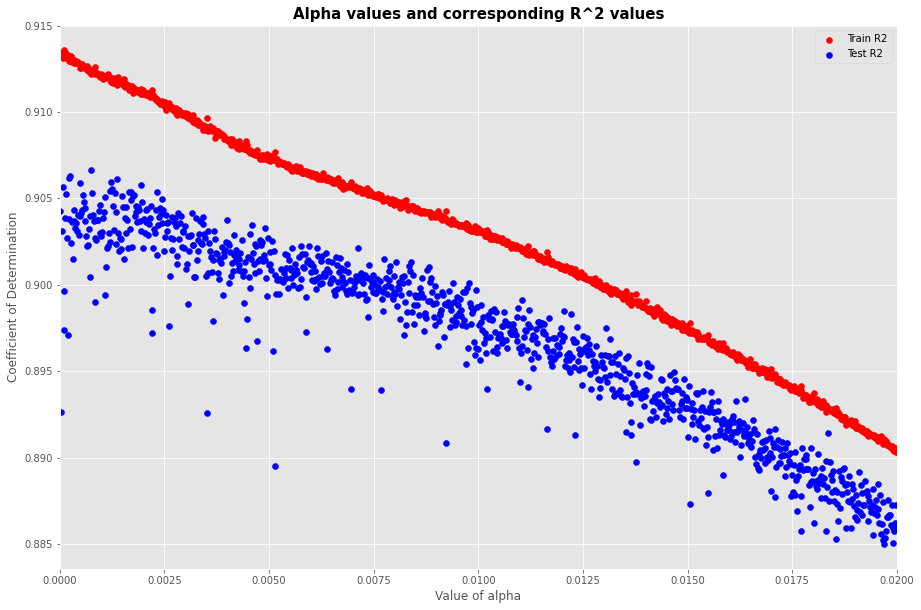

In [27]:
plt.figure(figsize = (15,10))
plt.scatter(alphas, lasso_train, c = 'red')
plt.scatter(alphas, lasso_test, c = 'blue')
plt.xlim([0,0.02])
plt.title(r'Alpha values and corresponding R^2 values',fontsize = 15, fontweight = 'bold')
plt.xlabel('Value of alpha')
plt.ylabel('Coefficient of Determination')
plt.legend(['Train R2', 'Test R2'])

In [28]:
alpha_ind = lasso_test.index(max(lasso_test))
f'alpha: {alphas[alpha_ind]}, train_score: {lasso_train[alpha_ind]}, test_score: {lasso_test[alpha_ind]}'

'alpha: 0.0007503703703703704, train_score: 0.9122204042375237, test_score: 0.9066290009848321'

In [29]:
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)
lasso = Lasso()
lasso.set_params(alpha = alphas[alpha_ind])
lasso.fit(Xtrain,ytrain)

lasso_train_results = lasso.score(Xtrain,ytrain)
lasso_test_results = lasso.score(Xtest,ytest)
print(f'Lasso train score: {lasso_train_results}')
print(f'Lasso test score: {lasso_test_results}')

Lasso train score: 0.9114649743492261
Lasso test score: 0.8935997333317844


#### Test linear regression before removing columns

In [30]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()

ols.fit(Xtrain,ytrain)

print(f'Linear regression training score: {ols.score(Xtrain,ytrain)}')
print(f'Linear regression testing score: {ols.score(Xtest,ytest)}')

from sklearn.metrics import mean_squared_error
y_pred = ols.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred,squared = False)
print(f'Linear regression RMSE: {RMSE}')

Linear regression training score: 0.9124189176323501
Linear regression testing score: 0.8916755702922323
Linear regression RMSE: 0.12401495601887208


In [31]:
for col, coef in zip(numeric_features.columns,lasso.coef_):
    print(f'{col}:   {coef}')

GrLivArea:   0.11320432859284106
LotFrontage:   0.023276910814311665
LotArea:   0.023992085639867627
Street:   0.004128690545420658
Utilities:   0.0025514511695853134
OverallQual:   0.09273442673774517
OverallCond:   0.05444998323559364
YearBuilt:   0.0693347764338978
YearRemodAdd:   0.009896571189035197
MasVnrArea:   -0.0006770940786262711
ExterQual:   0.005445151734617169
ExterCond:   -0.001998997506510512
BsmtQual:   0.018485518031037
BsmtCond:   0.0
BsmtFinSF1:   0.033841416927428467
BsmtFinSF2:   0.0049292092579102005
BsmtUnfSF:   -0.0
TotalBsmtSF:   0.03495088815112887
HeatingQC:   0.016104588705374918
CentralAir:   0.0140026689744993
1stFlrSF:   0.014428205985421601
2ndFlrSF:   0.0
LowQualFinSF:   -0.00647415060321121
BsmtFullBath:   0.0114698354989906
BsmtHalfBath:   0.0
FullBath:   0.004071530982667314
HalfBath:   0.004271847076815342
BedroomAbvGr:   -0.008891261814998807
KitchenAbvGr:   -0.012051497984798725
KitchenQual:   0.015912947258287406
TotRmsAbvGrd:   0.01533431178254

In [32]:
#Identify columns from Lasso regression that can be removed from model
coefs = lasso.coef_
zero_idx = np.where(coefs == 0)
numeric_features.columns[zero_idx]

Index(['BsmtCond', 'BsmtUnfSF', '2ndFlrSF', 'BsmtHalfBath', 'GarageQual',
       'dist_airport'],
      dtype='object')

# Drop Features Post-lasso

In [33]:
post_lasso = numeric_features.drop(numeric_features.columns[zero_idx],axis = 1)

In [34]:
Xtrain,Xtest,ytrain,ytest = train_test_split(post_lasso,y_Logprice)

Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)


ols2 = LinearRegression()
ols2.fit(Xtrain,ytrain)

LinearRegression()

In [35]:
print(f'Post-lasso training score: {ols2.score(Xtrain,ytrain)}')
print(f'Post-lasso testing score: {ols2.score(Xtest,ytest)}')

y_pred = ols2.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred,squared=False)
print(f'Post-lasso RMSE: {RMSE}')

Post-lasso training score: 0.9151451549226544
Post-lasso testing score: 0.8824299740616269
Post-lasso RMSE: 0.13673803668626505


# Five-Fold cross-validation for OLS

In [36]:
ols_pipe = Pipeline(steps = [('ss',StandardScaler()),('ols',LinearRegression())])
cv_res2 =cross_validate(ols_pipe, Xtrain,ytrain ,cv = cv, return_train_score = True)

In [37]:
print(f"Testing score: {cv_res2['test_score'].mean()}")
print(f"Training score: {cv_res2['train_score'].mean()}")

neg_RMSE = cross_val_score(ols_pipe, Xtrain, ytrain, scoring = 'neg_root_mean_squared_error', cv = cv)


print(f'Cross-validated RMSE is: {np.mean(np.abs(neg_RMSE))}')

Testing score: -1.5409555557532892e+52
Training score: 0.9160100905054269
Cross-validated RMSE is: 0.11675047526014652


<p>Linear regression runs into issues during 5-fold CV</p>

In [38]:
cv_res2

{'fit_time': array([0.01600981, 0.01323891, 0.01336598, 0.01179099, 0.0117662 ]),
 'score_time': array([0.00053501, 0.00051403, 0.00035   , 0.00032496, 0.00030088]),
 'test_score': array([ 9.19649023e-01, -7.70477778e+52,  9.31284576e-01,  9.23009298e-01,
         8.87576879e-01]),
 'train_score': array([0.91327963, 0.92479713, 0.91023231, 0.91190878, 0.91983261])}

#### Assessing errors meet linear regression assumptions

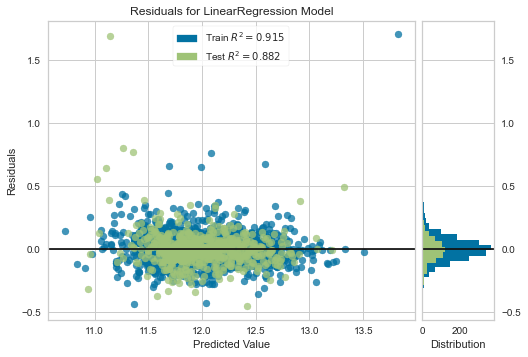

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [39]:
from yellowbrick.regressor import ResidualsPlot
ols2 = LinearRegression()
visualizer = ResidualsPlot(ols2)
visualizer.fit(Xtrain, ytrain) 
visualizer.score(Xtest, ytest)  
visualizer.show() 

## Regressing entire dataset to evaluate linear relationships between features and price

In [40]:
ols_described = LinearRegression()
Y = y_Logprice
X = sc.fit_transform(post_lasso)
ols_described.fit(X,Y)

LinearRegression()

Text(0.5, 1.0, 'Standardized betas in log(SalePrice) linear model')

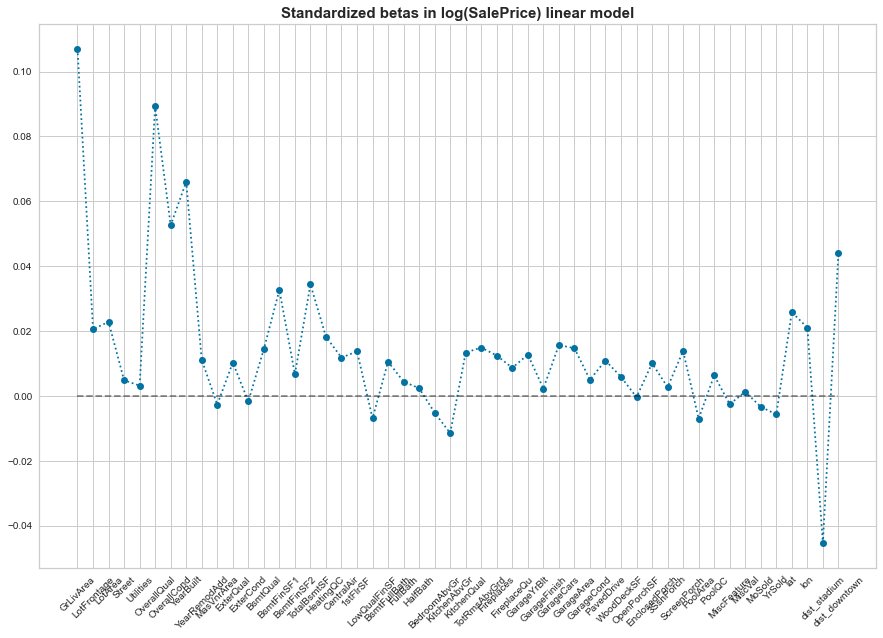

In [41]:
plt.figure(figsize = (15,10))
plt.plot(range(len(post_lasso.columns)),ols_described.coef_,'bo:')
plt.plot(range(len(post_lasso.columns)),np.array([0 for zero in range(len(post_lasso.columns))]),'k--',alpha = 0.49)
plt.xticks(range(len(post_lasso.columns)),labels = post_lasso.columns, rotation = 45)
plt.title('Standardized betas in log(SalePrice) linear model', fontsize = 15, fontweight = 'bold')

<p>Most influential features in the linear model are GrLivArea, OverallQual, OverallCond, and YearBuilt</p>

In [42]:
import statsmodels.api as sm
X = sm.add_constant(X)
OLS = sm.OLS(Y,X)
results = OLS.fit()

names = post_lasso.columns.tolist()
names.insert(0,'constant')
print(results.summary(xname = names))


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     500.1
Date:                Sun, 07 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:17:00   Log-Likelihood:                 1860.8
No. Observations:                2568   AIC:                            -3620.
Df Residuals:                    2517   BIC:                            -3321.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
constant         12.0126      0.002   5140.540

## Gradient Boosting

In [43]:
from sklearn.compose import ColumnTransformer

#Subclass is of numeric dtype, but are different house types
tree_prices['MSSubClass'] = tree_prices['MSSubClass'].astype(str)

tree_features = tree_prices.drop(['PID','SalePrice','Price_sqft'],axis = 1)

In [44]:
cat_cols = tree_features.select_dtypes(include = 'object').columns.tolist()
num_cols = tree_features.select_dtypes(exclude = 'object').columns.tolist()

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

ohe = OneHotEncoder(sparse = False,handle_unknown='ignore')

processing = ColumnTransformer(transformers = [('ohe',ohe, cat_cols),
                                               ('sc',StandardScaler(),num_cols)],remainder = 'passthrough')

Xtrain,Xtest,ytrain,ytest = train_test_split(tree_features,y_Logprice)
tree_pipe = Pipeline(steps = [('process',processing),('gb',GradientBoostingRegressor())])
tree_pipe.fit(Xtrain,ytrain)

Pipeline(steps=[('process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['MSSubClass', 'MSZoning',
                                                   'Street', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Ex...


In [46]:
print(tree_pipe.score(Xtrain,ytrain))
print(tree_pipe.score(Xtest,ytest))

y_pred = tree_pipe.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred,squared = False)
print(f'Gradient Boosting RMSE: {RMSE}')

0.9611590073776185
0.8999351426113418
Gradient Boosting RMSE: 0.12682029864234243


In [47]:
Xtrain,Xtest,ytrain,ytest = train_test_split(tree_features,y_Logprice)
tree_cv =cross_validate(tree_pipe, Xtrain,ytrain,cv = cv, return_train_score = True)

In [48]:
tree_cv

{'fit_time': array([0.96807408, 0.95134997, 0.95462799, 0.95235014, 0.958112  ]),
 'score_time': array([0.00933719, 0.00980687, 0.00930214, 0.00964093, 0.00943494]),
 'test_score': array([0.90383253, 0.90868074, 0.88925008, 0.87726356, 0.931848  ]),
 'train_score': array([0.96471296, 0.9631886 , 0.96587497, 0.96577303, 0.96441149])}

In [49]:
print(f"CV linear regression testing score: {cv_res2['test_score'].mean()}")
print(f"CV gradient boosted testing score: {np.mean(tree_cv['test_score'])}")

CV linear regression testing score: -1.5409555557532892e+52
CV gradient boosted testing score: 0.9021749828743749


<p>Gradient boosted model outperforms multiple linear regression.</p>

In [50]:
neg_RMSE = cross_val_score(tree_pipe, tree_features, y_Logprice, scoring = 'neg_root_mean_squared_error', cv = cv)
print(f'Cross-validated RMSE is: {np.mean(np.abs(neg_RMSE))}')

Cross-validated RMSE is: 0.11377854254129197


In [51]:
predicted_prices = np.exp(tree_pipe.predict(tree_features))

In [52]:
price_comp = pd.DataFrame({'Actual':tree_prices['SalePrice'],'Predicted':predicted_prices})

In [53]:
price_comp['Residuals'] = price_comp.Actual - price_comp.Predicted
price_comp['absResiduals'] = np.abs(price_comp['Residuals'])

In [54]:
price_comp.describe()

,Actual,Predicted,Residuals,absResiduals
count,2568.000000,2568.000000,2568.000000,2568.000000
mean,177941.813863,177236.964290,704.849573,10727.567320
std,75120.582411,72810.174073,18066.850894,14552.751501
min,12789.000000,39007.793669,-497788.898021,13.042162
25%,129900.000000,130985.521148,-6790.968410,3384.935101
50%,159500.000000,157957.419986,341.864721,7428.808567
75%,209500.000000,205958.865775,8033.375992,14265.308228
max,755000.000000,682538.898021,147280.367385,497788.898021


In [55]:
tree_prices['Predicted'] = price_comp.Predicted

In [56]:
tree_prices.head(10)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,YrSold,SaleType,SaleCondition,lat,lon,dist_stadium,dist_downtown,dist_airport,Price_sqft,Predicted
0,909176150,856,126000,30,RL,58.769231,7890,Pave,DNE,Reg,...,2010,WD,Normal,42.018564,-93.651619,0.835068,1.997560,2.024702,147.196262,123538.551620
1,905476230,1049,139500,120,RL,42.000000,4235,Pave,DNE,Reg,...,2009,WD,Normal,42.024855,-93.663671,1.558185,2.566078,2.777751,132.983794,131532.089269
3,911128020,1001,124900,30,C (all),60.000000,6060,Pave,DNE,Reg,...,2007,WD,Normal,42.021548,-93.614068,1.173123,0.245745,1.616918,124.775225,118445.107093
4,535377150,1039,114000,70,RL,80.000000,8146,Pave,DNE,Reg,...,2009,WD,Normal,42.037391,-93.612207,1.897608,0.852123,2.704025,109.720885,104846.638942
5,534177230,1665,227000,60,RL,70.000000,8400,Pave,DNE,Reg,...,2009,WD,Normal,42.044554,-93.631818,1.966935,1.631256,3.184678,136.336336,216376.198902
6,908128060,1922,198500,85,RL,64.000000,7301,Pave,DNE,Reg,...,2009,ConLD,Normal,42.019009,-93.672987,1.928481,3.074472,2.950477,103.277836,221539.322673
7,902135020,936,93000,20,RM,60.000000,6000,Pave,Pave,Reg,...,2009,WD,Normal,42.031162,-93.612561,1.576285,0.423079,2.279611,99.358974,92803.603518
8,528228540,1246,187687,20,RL,53.000000,3710,Pave,DNE,Reg,...,2008,New,Partial,42.063284,-93.641569,3.263445,2.997337,4.548662,150.631621,171133.608369
9,923426010,889,137500,20,RL,74.000000,12395,Pave,DNE,Reg,...,2008,WD,Normal,41.986496,-93.603619,2.632937,2.715708,1.292634,154.668166,136152.645541
10,908186050,1072,140000,180,RM,35.000000,3675,Pave,DNE,Reg,...,2007,WD,Normal,42.018966,-93.669462,1.747762,2.895315,2.790099,130.597015,143457.985917


In [57]:
tree_prices['PriceBin'] = pd.qcut(tree_prices['SalePrice'],q=4,labels = ['Quart_1','Quart_2','Quart_3','Quart_4'])
tree_prices['Residuals'] = price_comp['Residuals']

Text(0, 0.5, 'Actual price - predicted price (USD)')

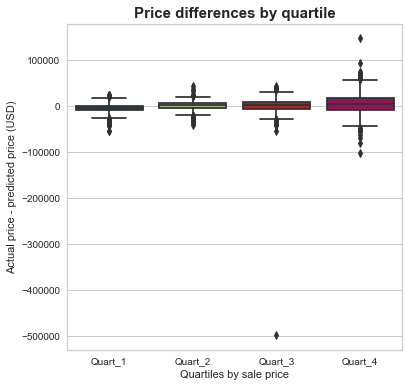

In [58]:
plt.figure(figsize = (6,6))
sns.boxplot(data = tree_prices, x = 'PriceBin', y = 'Residuals')
plt.title('Price differences by quartile',fontsize = 15, fontweight = 'bold')
plt.xlabel('Quartiles by sale price')
plt.ylabel('Actual price - predicted price (USD)')

<p>Gradient boosted model performs better on lower priced homes than more expensive ones.</p>